# UTR Data Analysis

My goal here to to create a function F that takes as input two UTR ratings and outputs the probability that the highest rating player will win.

Step 1: Data Collection

The final output here should be a CSV with the columns "rating1", "rating2" and "results" (1 if rating1 won and 2 if rating 2 won).

In [158]:
import requests
import pandas as pd
from dataclasses import dataclass
from typing import Literal
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

JWT = "<add your JWT here>"

In [84]:
@dataclass(frozen=True)
class Player:
    id: str
    name: str
    rating: float
    rating_progress: int
    gender: Literal['M', 'F']

    @classmethod
    def from_raw_player(cls, raw_player):
        return cls(
            id=raw_player['id'],
            name=raw_player['firstName'] + ' ' + raw_player['lastName'],
            rating=raw_player['singlesUtr'],
            rating_progress=int(raw_player['ratingProgressSingles']) if raw_player.get('ratingProgressSingles') else 0,
            gender='M' if raw_player.get('gender') == 'M' else 'F',
        )


@dataclass(frozen=True)
class Match:
    id: str
    winner: Player
    loser: Player

    @classmethod
    def from_raw_match(cls, raw_match):
        raw_players = raw_match['results'][0]['players']
        return cls(
            id=str(raw_match['id']),
            winner=Player.from_raw_player(raw_players['winner1']),
            loser=Player.from_raw_player(raw_players['loser1']),
        )

In [107]:
class UtrApi:
    def __init__(self, jwt):
        self.jwt = jwt

    def get_valid_matches(self, player_id) -> list[Match]:
        response = requests.get(
            f'https://api.universaltennis.com/v4/player/{player_id}/results',
            params={'type': 's'},
            cookies={'jwt': self.jwt}
        )
        try:
            results = response.json()
            events = results['events']
            raw_matches = [draw for event in events for draw in event['draws']]
        except Exception as e:
            print("error: ", e)
            return []
        
        all_matches: list[Match] = []
        for raw_match in raw_matches:
            try:
                all_matches.append(Match.from_raw_match(raw_match))
            except:
                print("error")
                pass

        matches = []
        for match in all_matches:
            if match.winner.rating_progress + match.loser.rating_progress > 180:
                matches.append(match)

        return matches

In [112]:
class UtrMatchCrawler:
    def __init__(self, utr_api: UtrApi, root_id: int):
        self.utr_api = utr_api
        self.root_id = root_id

        self._matches: list[Match] = []
        self._player_queue: set[int] = {root_id}
        self._visited_players: set[int] = {root_id}
        self._recorded_matches: set[int] = set()

    def crawl(self, max_player_visits: int = 100):
        for i in range(max_player_visits):
            if not self._player_queue:
                print('No more players to visit')
                break

            player_id = self._player_queue.pop()
            print(f'{i + 1}. Visiting player {player_id}')

            matches = self.utr_api.get_valid_matches(player_id)
            for match in matches:
                if match.id not in self._recorded_matches:
                    self._matches.append(match)
                    self._recorded_matches.add(match.id)

                    winner = match.winner
                    if winner.id not in self._visited_players:
                        self._player_queue.add(winner.id)
                        self._visited_players.add(winner.id)

                    loser = match.loser
                    if loser.id not in self._visited_players:
                        self._player_queue.add(loser.id)
                        self._visited_players.add(loser.id)

crawler = UtrMatchCrawler(UtrApi(JWT), root_id=215710)

In [209]:
print("Player Queue Size: ", len(crawler._player_queue))
crawler.crawl(max_player_visits=1000)
print("Number of Matches: ", len(crawler._matches))

Player Queue Size:  16365
1. Visiting player 2522774
2. Visiting player 1032533
3. Visiting player 2942845
4. Visiting player 3281418
5. Visiting player 3665306
6. Visiting player 235622
7. Visiting player 3620525
8. Visiting player 96338
9. Visiting player 3111169
10. Visiting player 407126
11. Visiting player 276601
12. Visiting player 266885
13. Visiting player 3543570
14. Visiting player 4088941
15. Visiting player 3059158
16. Visiting player 2790555
17. Visiting player 2627327
18. Visiting player 3837949
19. Visiting player 1965179
20. Visiting player 3162466
21. Visiting player 55402
22. Visiting player 2626400
23. Visiting player 1846726
24. Visiting player 3708322
25. Visiting player 2912537
26. Visiting player 2807607
27. Visiting player 455691
28. Visiting player 274584
29. Visiting player 2511691
30. Visiting player 435888
31. Visiting player 1416893
32. Visiting player 1905765
33. Visiting player 1705349
34. Visiting player 3129191
35. Visiting player 1387494
36. Visiting p

In [210]:
winner_df = pd.DataFrame(
    {
        'p1_rating': [match.winner.rating for match in crawler._matches],
        'p2_rating': [match.loser.rating for match in crawler._matches],
        'outcome': [1 for _ in crawler._matches],
    }
)
loser_df = pd.DataFrame(
    {
        'p1_rating': [match.loser.rating for match in crawler._matches],
        'p2_rating': [match.winner.rating for match in crawler._matches],
        'outcome': [0 for _ in crawler._matches],
    }
)
df = pd.concat([winner_df, loser_df])
df = df.sample(frac=1)
df

,p1_rating,p2_rating,outcome
20751,14.73,14.71,1
73669,8.88,8.84,1
33196,11.30,11.29,1
63502,9.43,8.20,1
72792,9.91,9.54,0
...,...,...,...
19545,6.54,6.55,0
62513,9.05,7.99,1
32881,2.90,8.28,0
30285,10.86,11.17,0


/Users/guilemieux/Library/Python/3.9/lib/python/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


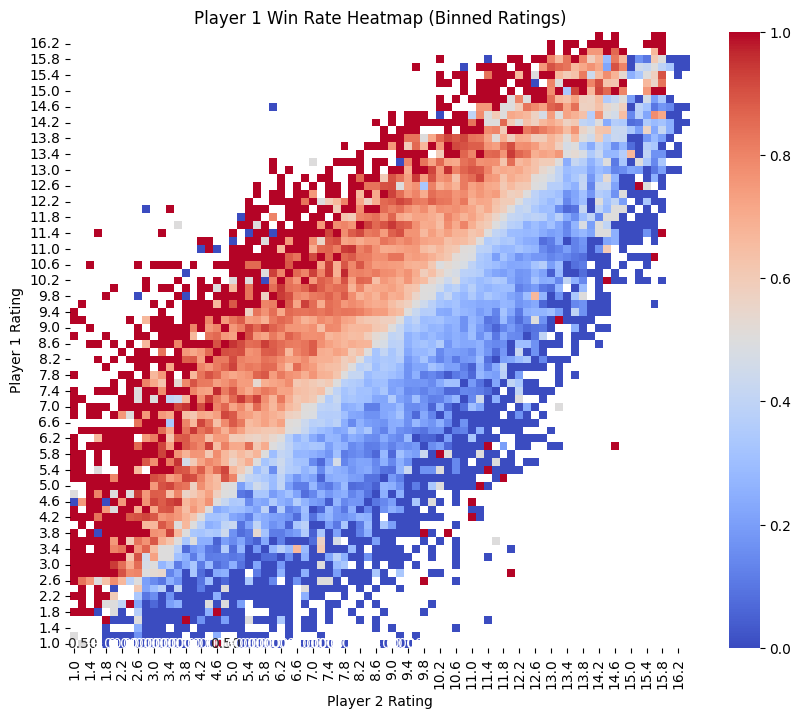

In [237]:
bins = [i/5 for i in range(0, 171)]
df['p1_rating_bin'] = pd.cut(df['p1_rating'], bins=bins, labels=bins[:-1], right=False)
df['p2_rating_bin'] = pd.cut(df['p2_rating'], bins=bins, labels=bins[:-1], right=False)

pivot_table = df.pivot_table(index='p1_rating_bin', columns='p2_rating_bin', values='outcome', aggfunc='mean')
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, cmap='coolwarm', vmin=0, vmax=1, annot=True, fmt=".2f")
plt.title('Player 1 Win Rate Heatmap (Binned Ratings)')
plt.xlabel('Player 2 Rating')
plt.ylabel('Player 1 Rating')
plt.gca().invert_yaxis()
plt.show()

In [270]:
df['difference'] = df['p1_rating'] - df['p2_rating']
df['sum'] = df['p1_rating'] + df['p2_rating']

X = df[['difference']].values
y = df['outcome'].values

In [272]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Splitting into training and test sets (for evaluation purposes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
regressor = LogisticRegression()
regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model (using MSE as an example metric)
mse = accuracy_score(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.6960118866713944


In [282]:
def predict(p1_rating, p2_rating):
    predicted_win_rate = regressor.predict_proba([[p1_rating - p2_rating]])
    return predicted_win_rate[:, 1]

predict(10.01, 10.68)

array([0.38633388])

In [295]:
import numpy as np

# Create a grid of values
x_values = np.linspace(0, 17, 100)  # Adjust the number as needed for granularity
y_values = np.linspace(0, 17, 100)

# Create a meshgrid of x and y values
xx, yy = np.meshgrid(x_values, y_values)

differences = xx - yy

# Flatten and combine the grid to feed into the model
grid = np.c_[differences.ravel()]

# Get predictions from the neural network
predictions = regressor.predict_proba(grid)[:, 0]

# Reshape predictions to match the shape of xx and yy
predictions = predictions.reshape(xx.shape)


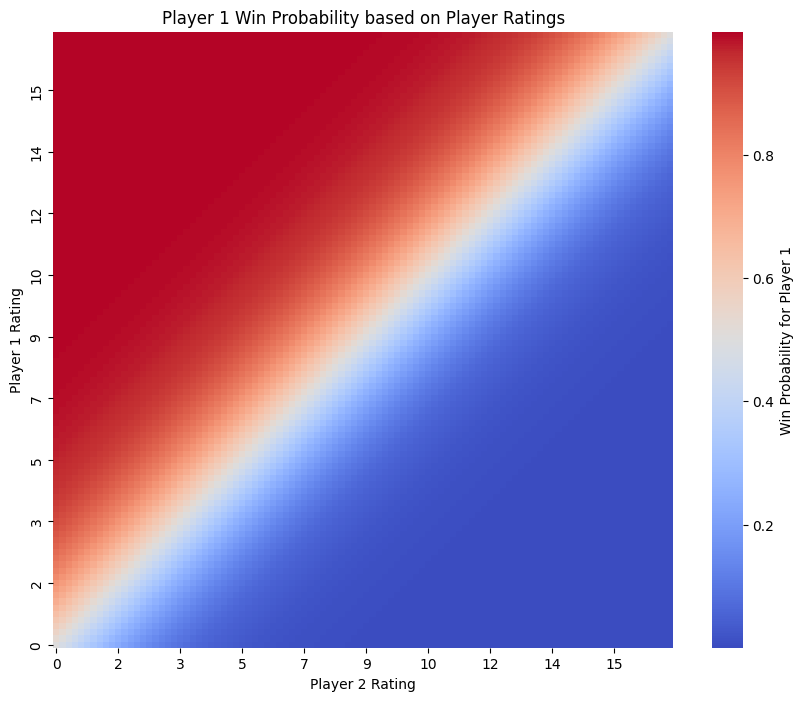

In [296]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(predictions, cmap='coolwarm', cbar_kws={'label': 'Win Probability for Player 1'}, xticklabels=10, yticklabels=10)
plt.title('Player 1 Win Probability based on Player Ratings')
plt.xlabel('Player 2 Rating')
plt.ylabel('Player 1 Rating')

# Modify tick labels to reflect actual rating values
xticks = plt.xticks()
plt.xticks(xticks[0], [round(x_values[int(tick)]) for tick in xticks[0]])

yticks = plt.yticks()
plt.yticks(yticks[0], [round(y_values[int(tick)]) for tick in yticks[0]])

plt.gca().invert_yaxis()  # Make the y-axis incrementing from bottom to top
plt.show()

In [293]:
regressor.coef_

array([[0.68776333]])

In [294]:
def win_prob(diff: float) -> float:
    return 1 / (1 + np.exp(-0.68776333 * diff))


win_prob(10.01 - 10.68)

0.3867957193556974